# Deploy the model to a sagemaker endpoint

In [ ]:
!pip install -r requirements.txt

In [ ]:
import os
import boto3
import sagemaker
from sagemaker.pytorch.model import PyTorchModel, PyTorchPredictor

In [ ]:
# modify these variables according to your configuration
endpoint_name = 'yolov8-sagemaker-endpoint'
role = 'AmazonSageMaker-ExecutionRole-...'

bucket = 's3-bucket-name'
model_artifacts = 'model_artifacts.tar.gz'
model_s3_uri = os.path.join('s3://', bucket, model_artifacts)

In [ ]:
# archive and zip codes folder and upload it to s3
!wget https://github.com/ultralytics/assets/releases/download/v0.0.0/yolov8x.pt
!tar -cvzf {model_artifacts} inference_code/ yolov8x.pt
!aws s3 cp {model_artifacts} {model_s3_uri}

In [ ]:
sess = sagemaker.Session()

# instance types: https://aws.amazon.com/sagemaker/pricing/?p=pm&c=sm&z=4
instance_type = 'ml.t2.medium'

# Deploy to an endpoint with python 3.8 and pytorch 1.10.2
model = PyTorchModel(
    model_data=model_s3_uri,
    entry_point='inference.py',
    source_dir='inference_code',
    role=role,
    framework_version='1.10.2',
    py_version='py38'
)

client = boto3.client('sagemaker')
# Delete model in order to force the script to create it again
try:
    client.delete_model(ModelName=endpoint_name)    
except Exception as e:
    # model does not exist
    pass   

# Delete endpoint configuration in order to force the script to create it again
try:
    client.delete_endpoint_config(EndpointConfigName=endpoint_name)
except Exception as e:
    # endpoint configuration does not exist
    pass 

try:
    # create endpoint
    predictor = model.deploy(
        instance_type=instance_type,
        initial_instance_count=1,
        endpoint_name=endpoint_name
    )
except Exception as e:
    # endpoint already exists, so update it
    predictor = PyTorchPredictor(endpoint_name=endpoint_name)
    predictor.update_endpoint(
        model_name=model.name,
        instance_type=instance_type,
        initial_instance_count=1,
    )

# Sagemaker inference

In [ ]:
labels_path = "data/labels.txt"

In [ ]:
img_key = 'highway.png'
img_local_path = os.path.join('data', img_key)
!aws s3 cp {img_local_path} {os.path.join('s3://', bucket, img_key)}

In [ ]:
from detector import Detector

detector = Detector(endpoint_name=endpoint_name,
                    labels_path=labels_path)
boxes, scores = detector.detect(img_bucket=bucket, 
                            img_key=img_key,
                            detection_classes=['car', 'truck'])

'number of detected objects:', len(boxes)

# Visualize the predictions

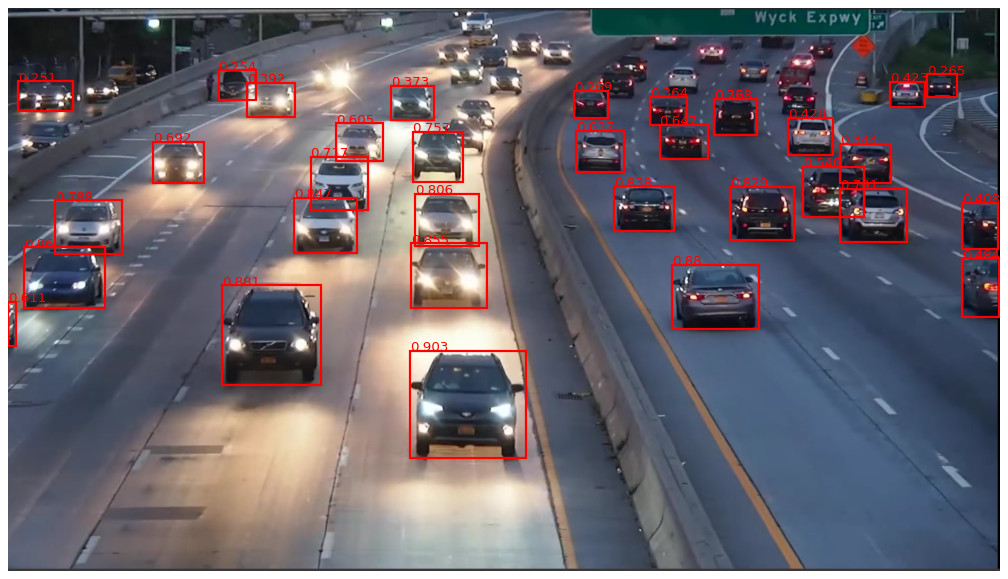

In [7]:
from PIL import Image
import matplotlib.pyplot as plt

image = Image.open(img_local_path).convert('RGB')

plt.figure(figsize=(16, 12), dpi=80)

for i in range(len(boxes)):
    x_min, y_min, x_max, y_max = boxes[i]
    x, y, w, h = x_min, y_min, x_max-x_min, y_max-y_min
    rect = plt.Rectangle((x, y), w, h, color='red', fill=False, lw=2)
    plt.gca().add_patch(rect)  
    
    score = scores[i].round(3)
    plt.text(x, y, score, fontsize=12, color='red')
    
plt.axis('off')
plt.imshow(image)
plt.show()